Load SSD model

In [2]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
sys.path.insert(0, PROJECT_ROOT)

print("Project root added to path:", PROJECT_ROOT)


import torch

from models.SSD.config import NUM_CLASSES
from models.SSD.models.ssd import SSD

DEVICE = torch.device("cpu")  # SSD evaluation on CPU for consistency

print("NUM_CLASSES =", NUM_CLASSES)
print("DEVICE =", DEVICE)

Project root added to path: /Users/prekshadahal/Desktop/Masters/Year 2/Computer Vision/Face-Mask Detection
NUM_CLASSES = 4
DEVICE = cpu


Run inference

In [3]:
model = SSD(num_classes=NUM_CLASSES)

model.load_state_dict(
    torch.load("../outputs/checkpoints/ssd_epoch_30.pth", map_location=DEVICE)
)

model.to(DEVICE)
model.eval()

print("✅ SSD checkpoint loaded and ready")

✅ SSD checkpoint loaded and ready


In [4]:
from torch.utils.data import DataLoader
from models.SSD.utils.dataset import MaskDataset
import pandas as pd

df = pd.read_csv("../data/processed/annotations.csv")

# Same split as YOLO
val_df = df.sample(frac=0.2, random_state=42)

val_dataset = MaskDataset(
    val_df,
    image_dir="../data/processed/images",
    label_map={
        "with_mask": 1,
        "without_mask": 2,
        "mask_weared_incorrect": 3
    }
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False
)

print("Validation samples:", len(val_dataset))

Validation samples: 700


In [5]:
all_preds = []
all_targets = []

with torch.no_grad():
    for images, gt_boxes, gt_labels in val_loader:
        images = images.to(DEVICE)

        cls_preds, box_preds = model(images)

        all_preds.append((cls_preds, box_preds))
        all_targets.append((gt_boxes, gt_labels))

print("Inference completed on validation set")

Inference completed on validation set


Decode boxes + apply softmax + confidence threshold + NMS

In [6]:
import torch
import torch.nn.functional as F
from torchvision.ops import nms

def postprocess_ssd(cls_preds, box_preds, score_thresh=0.5, iou_thresh=0.5):
    """
    Post-process SSD outputs for your current implementation
    """
    # Concatenate feature maps if multiple (your SSD might already return flattened)
    if isinstance(cls_preds, list):
        cls_preds = torch.cat([c.view(-1, NUM_CLASSES) for c in cls_preds], dim=0)
        box_preds = torch.cat([b.view(-1, 4) for b in box_preds], dim=0)
    else:
        cls_preds = cls_preds.view(-1, NUM_CLASSES)
        box_preds = box_preds.view(-1, 4)

    # Softmax probabilities
    scores = F.softmax(cls_preds, dim=1)

    # Remove background class (0)
    scores_bg_removed = scores[:, 1:]
    labels = scores_bg_removed.argmax(dim=1) + 1
    confidences = scores_bg_removed.max(dim=1).values

    # Confidence threshold
    mask = confidences > score_thresh
    boxes = box_preds[mask]
    labels = labels[mask]
    confidences = confidences[mask]

    # Apply NMS
    if boxes.shape[0] > 0:
        keep = nms(boxes, confidences, iou_thresh)
        boxes = boxes[keep]
        labels = labels[keep]
        confidences = confidences[keep]

    return boxes, labels, confidences

Compute IoU between predicted boxes and ground truth

In [7]:
def compute_iou(box1, box2):
    """Compute IoU between 2 boxes [x1,y1,x2,y2]"""
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter = max(0, xB - xA) * max(0, yB - yA)
    area1 = (box1[2]-box1[0])*(box1[3]-box1[1])
    area2 = (box2[2]-box2[0])*(box2[3]-box2[1])
    union = area1 + area2 - inter

    return inter / union if union > 0 else 0

Precision/Recall

In [8]:
TP, FP, FN = 0, 0, 0

for (cls_preds, box_preds), (gt_boxes, gt_labels) in zip(all_preds, all_targets):
    pred_boxes, pred_labels, pred_scores = postprocess_ssd(cls_preds, box_preds, score_thresh=0.5)
    
    gt_boxes = gt_boxes[0]  # batch_size=1
    gt_labels = gt_labels[0]

    matched = set()
    for pb, pl in zip(pred_boxes, pred_labels):
        found = False
        for i, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
            if i in matched:
                continue
            if pl == gl and compute_iou(pb, gb) >= 0.5:
                TP += 1
                matched.add(i)
                found = True
                break
        if not found:
            FP += 1
    FN += len(gt_boxes) - len(matched)

precision = TP / (TP + FP + 1e-3)
recall = TP / (TP + FN + 1e-3)

print("SSD Precision:", precision)
print("SSD Recall:", recall)

SSD Precision: 0.0003831356444535702
SSD Recall: 0.13714266122476967


FPS Benchmark

In [9]:
import time

start = time.time()
with torch.no_grad():
    for images, _, _ in val_loader:
        images = images.to(DEVICE)
        _ = model(images)
end = time.time()

fps = len(val_loader) / (end - start)
print(f"SSD FPS: {fps:.2f}")

SSD FPS: 4.12


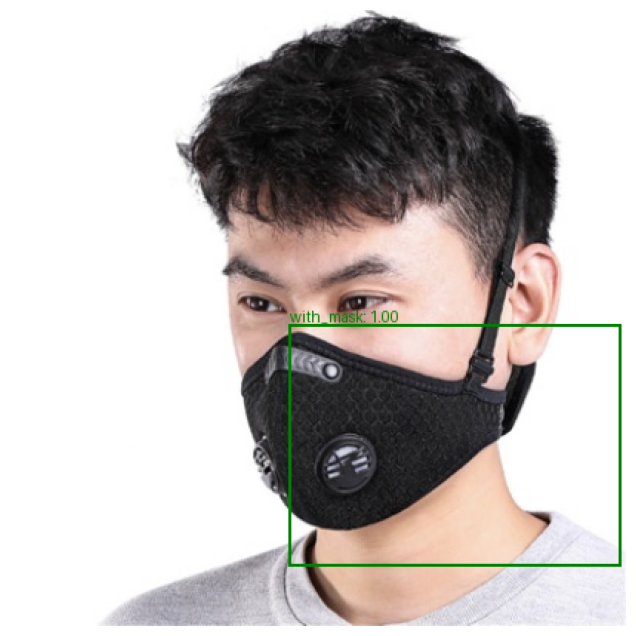

In [10]:
import torch
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torchvision.transforms as T

# -------------------------------
# 1️⃣ Label map and colors
# -------------------------------
CLASS_MAP = {1: "with_mask", 2: "without_mask", 3: "mask_incorrect"}
CLASS_COLORS = {
    "with_mask": "green",
    "without_mask": "red",
    "mask_incorrect": "orange"
}

# -------------------------------
# 2️⃣ Decode SSD outputs
# -------------------------------
def decode_ssd(preds, conf_threshold=0.5, img_size=(1,1)):
    cls_preds, box_preds = preds
    scores = torch.softmax(cls_preds, dim=-1)

    H, W = img_size

    best_conf = -1
    best_box = None
    best_label = None

    for anchor_idx in range(box_preds.shape[1]):
        class_scores, class_labels = torch.max(
            scores[0, anchor_idx, 1:], dim=0
        )

        conf = class_scores.item()
        label_id = class_labels.item() + 1

        if conf > best_conf:
            xmin = box_preds[0, anchor_idx, 0].item() * W
            ymin = box_preds[0, anchor_idx, 1].item() * H
            xmax = box_preds[0, anchor_idx, 2].item() * W
            ymax = box_preds[0, anchor_idx, 3].item() * H

            best_conf = conf
            best_box = [xmin, ymin, xmax, ymax]
            best_label = CLASS_MAP[label_id]

    if best_box is None or best_conf < conf_threshold:
        return [], [], []

    return [best_box], [best_label], [best_conf]


def show_ssd_result(model, img_path, conf_threshold=0.5):
    """
    Visualize SSD predictions on a single image (robust version).
    """
    # Load image
    img = Image.open(img_path).convert("RGB")
    W, H = img.size

    # Transform to tensor
    transform = T.ToTensor()
    img_tensor = transform(img).unsqueeze(0)  # add batch dimension

    # Forward pass
    model.eval()
    with torch.no_grad():
        cls_preds, box_preds = model(img_tensor)

    # Decode predictions
    boxes, labels, confs = decode_ssd((cls_preds, box_preds), conf_threshold, img_size=(H, W))

    # Draw boxes
    draw = ImageDraw.Draw(img)
    if boxes:
        for box, label, conf in zip(boxes, labels, confs):
            xmin, ymin, xmax, ymax = box

            # Clamp coordinates to valid range
            xmin = max(0, min(xmin, W-1))
            xmax = max(0, min(xmax, W-1))
            ymin = max(0, min(ymin, H-1))
            ymax = max(0, min(ymax, H-1))

            # Ensure xmin <= xmax, ymin <= ymax
            if xmax < xmin: xmax = xmin + 1
            if ymax < ymin: ymax = ymin + 1

            color = CLASS_COLORS.get(label, "red")
            draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)
            draw.text((xmin, max(ymin-12, 0)), f"{label}: {conf:.2f}", fill=color)
    else:
        print("No predictions above the confidence threshold.")

    # Show image
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# 4️⃣ Example usage
img_path = "/Users/prekshadahal/Desktop/Masters/Year 2/Computer Vision/Face-Mask Detection/data/processed/images/img_3466.jpg"
show_ssd_result(model, img_path, conf_threshold=0.8)

# img_3463.jpg
# 3466
#3440

In [ ]:
import torch
import torch.nn.functional as F
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# 1️ DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # make sure 'model' is defined
# val_loader must also be defined

# VALIDATION FUNCTION (IMAGE-LEVEL CLASS)
def validate_simple(model, val_loader, device):
    """
    Validates the model on val_loader for image-level classification.
    Handles SSD-style multi-object labels by picking the first object per image.
    """
    model.eval()

    total_cls_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False):
            images = batch[0].to(device)
            labels_batch = batch[1]  # could be list of tensors per image

            # Convert multi-target labels to 1D tensor
            labels = []
            for lab in labels_batch:
                if torch.is_tensor(lab):
                    labels.append(lab[0])  # pick first object per image
                else:
                    labels.append(torch.tensor(0))  # default if empty
            labels = torch.stack(labels).to(device)

            # Forward pass
            cls_preds, _ = model(images)   # ignore box outputs

            # cls_preds shape: [B, grid, num_classes]
            cls_preds = cls_preds.mean(dim=1)  # average grid → image-level

            loss = F.cross_entropy(cls_preds, labels)
            total_cls_loss += loss.item()

            preds = torch.argmax(cls_preds, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return {
        "val/cls_loss": total_cls_loss / len(val_loader),
        "metrics/accuracy": correct / total
    }

# --------------------------------------------------
# 3️⃣ LOOP THROUGH CHECKPOINTS (SKIP MISSING)
# --------------------------------------------------
checkpoint_dir = Path("/Users/prekshadahal/Desktop/Masters/Year 2/Computer Vision/Face-Mask Detection/outputs/checkpoints")
results = []

for epoch in range(1, 31):
    ckpt_path = checkpoint_dir / f"ssd_epoch_{epoch}.pth"

    if not ckpt_path.exists():
        print(f"[⚠️ Warning] Checkpoint not found: {ckpt_path}, skipping.")
        continue

    # Load checkpoint
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)

    # Validate
    metrics = validate_simple(model, val_loader, device)

    # Store results
    results.append({
        "epoch": epoch,
        "val/cls_loss": metrics["val/cls_loss"],
        "metrics/accuracy": metrics["metrics/accuracy"]
    })

    print(f"[✅ Epoch {epoch}] val_loss={metrics['val/cls_loss']:.6f}, accuracy={metrics['metrics/accuracy']:.6f}")

# --------------------------------------------------
# 4️⃣ DISPLAY RESULTS LIKE A TABLE
# --------------------------------------------------
if results:
    df = pd.DataFrame(results)
    df = df.round(6)
    print("\nValidation Results:")
    display(df)
else:
    print("No checkpoints found. Make sure the path is correct.")

 34%|███▍      | 240/700 [01:00<01:58,  3.88it/s]